In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from datetime import date, timedelta

In [2]:
from pheno_metrics import pheno_fq_metrics

In [6]:
df_fq = pd.read_csv(r"../data/ground/diet_quality/All Years Locals Only Diet Quality.csv", parse_dates=['Date'])
df_ndvi = pd.read_csv('../data/extractions/cper_ndvi_means_2014_2024.csv', parse_dates=['date'])

In [7]:
outPATH = '../data/training/fecal_quality_2014_2023_pheno_metrics.csv'

In [17]:
df_fq = df_fq.rename(columns={'Pasture': 'PastureID'})

In [13]:
past_rename_dict = {'Crossroads': '25NW',
 'Elm': '20NW',
 'Headquarters': '7SE',
 'Highway': '21N',
 'Hilltank': '26W',
 'Nighthawk': '10S',
 'Ridgeline': '8E',
 'Saltflat': '17S',
 'Snowfence': '18S',
 'South': '31W'}

In [11]:
df_ndvi['DOY'] = df_ndvi['date'].dt.dayofyear

In [12]:
df_pheno = df_ndvi.groupby(['Pasture', 'Year']).progress_apply(lambda x: pheno_fq_metrics(x['NDVI'].values))

 13%|█▎        | 91/684 [00:23<00:15, 39.39it/s] /project/cper_neon_aop/cper_hls_veg_models/diet_quality/pheno_metrics.py:25: RuntimeWarning: overflow encountered in exp
  y = vmin + vmax * ( (1 / (1 + np.exp(-scaleS * (x - sos)))) + (1 / (1 + np.exp(scaleA * (x - eos)))) - 1 )
100%|██████████| 684/684 [00:44<00:00, 15.34it/s]


In [14]:
df_pheno = df_pheno.reset_index(names=['Pasture', 'Year', 'DOY'])

In [15]:
df_pheno['PastureID'] = df_pheno['Pasture'].apply(lambda x: past_rename_dict[x] if x in past_rename_dict.keys() else x)

In [18]:
df_fq.PastureID.unique()[[x not in df_pheno['PastureID'].unique() for x in df_fq.PastureID.unique()]]

array(['18S/17S', '17S/20NW', 'NH'], dtype=object)

In [19]:
df_fq.loc[df_fq['PastureID'] == 'NH', 'PastureID'] = '10S'

In [21]:
df_fq = df_fq.loc[~df_fq['PastureID'].isin(['18S/17S', '17S/20NW'])]

In [22]:
df_fq.PastureID.unique()[[x not in df_pheno['PastureID'].unique() for x in df_fq.PastureID.unique()]]

array([], dtype=object)

In [23]:
df_pheno['date'] = df_pheno.progress_apply(lambda x: date(x['Year'], 1, 1) + timedelta(x['DOY']), axis=1)

100%|██████████| 239286/239286 [00:02<00:00, 107479.56it/s]


In [25]:
for index, row in tqdm(df_fq.iterrows(), total=len(df_fq)):
    past = row['PastureID']
    # get observations over the week prior to sampling
    df_pheno_sub = df_pheno[(df_pheno['PastureID'] == row['PastureID']) &
    (df_pheno['date'] > row['Date'].date() - timedelta(days=7)) & 
    (df_pheno['date'] <= row['Date'].date())]
    # get observation on the sampling date
    df_pheno_last = df_pheno[(df_pheno['PastureID'] == row['PastureID']) &
    (df_pheno['date'] == row['Date'].date())]
    df_fq.loc[index, 'NDVI'] = df_pheno_sub['NDVI'].mean()
    df_fq.loc[index, 'NDVI_d30'] = df_pheno_sub['NDVI_d30'].mean()
    df_fq.loc[index, 'iNDVI'] = df_pheno_sub['iNDVI'].mean()
    df_fq.loc[index, 't_peak_IRG'] = df_pheno_last['t_peak_IRG'].values
    df_fq.loc[index, 'iNDVI_dry'] = df_pheno_sub['iNDVI_dry'].mean()

100%|██████████| 1058/1058 [00:59<00:00, 17.93it/s]


In [26]:
df_fq.to_csv(outPATH, index=False)

In [29]:
from sklearn.inspection import PartialDependenceDisplay
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl

In [30]:
rf_cp = pickle.load(open('../models/diet_quality/rf_cp_ndvi_2014_2019.pkl', 'rb'))
df_fq = pd.read_csv('../data/training/fecal_quality_2014_2023_pheno_metrics.csv')

In [31]:
cp_features = df_cp[['NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry']]

NameError: name 'df_cp' is not defined

In [146]:
# Use the forest's predict method on the test data
pred_cp = rf_cp.predict(cp_features)
# Calculate the squared absolute errors_dom
MSE_cp = np.mean((pred_cp - df_cp['CP'])**2)
# Print out the root mean squared error (RMSE)
print('RMSE CP:', np.sqrt(round(MSE_cp, 2)))
print('R2 CP: ', np.corrcoef(pred_cp, df_cp['CP'])[0, 1]**2)

RMSE CP: 0.6557438524302001
R2 CP:  0.9243752607085469


In [ ]:
########################################################
cp_levels = np.arange(6.5, 12.5, 0.5)
cp_grid_res = 20
cp_percentiles = [0, 1]
cp_lines = True
cp_labels = False
fig = plt.figure(figsize=(10, 10))
gs = mpl.gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], wspace=0.20)
gs_leg = mpl.gridspec.GridSpec(4, 5, width_ratios=[1, 1, 1, 1, 0.3], top=0.85, bottom=0.10)

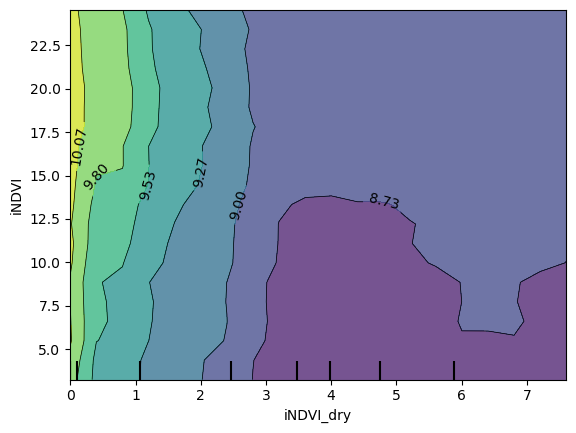

In [159]:
pdp1 = PartialDependenceDisplay.from_estimator(rf_cp,
                                               cp_features,
                                               [(4, 2)], 
                                               grid_resolution=cp_grid_res,
                                               #percentiles=(0,1), 
                                               #contour_kw={'levels': cp_levels},
                                               n_jobs=-1)

In [ ]:
ax1 = fig.add_subplot(gs[0, 0])
pdp1 = PartialDependenceDisplay.from_estimator(rf_cp, cp_features,
                        [(4, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax1,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

ax2 = fig.add_subplot(gs[0, 1])
pdp2 = PartialDependenceDisplay.from_estimator(rf_cp, cp_features,
                        [(1, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax2,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp2.axes_[0][0].set_xlabel('')
pdp2.axes_[0][0].set_ylabel('')

ax3 = fig.add_subplot(gs[0, 2])
pdp3 = PartialDependenceDisplay.from_estimator(rf_cp, cp_features,
                        [(3, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax3,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp3.axes_[0][0].set_xlabel('')
pdp3.axes_[0][0].set_ylabel('')

ax4 = fig.add_subplot(gs[0, 3])
pdp4 = PartialDependenceDisplay.from_estimator(rf_cp, cp_features,
                        [(0, 2)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax4,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp4.axes_[0][0].set_xlabel('')
pdp4.axes_[0][0].set_ylabel('')

ax5 = fig.add_subplot(gs[1, 1])
pdp5 = PartialDependenceDisplay.from_estimator(rf_cp, cp_features,
                        [(1, 4)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax5,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

ax6 = fig.add_subplot(gs[1, 2])
pdp6 = PartialDependenceDisplay.from_estimator(rf_cp, cp_features,
                        [(3, 4)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax6,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp6.axes_[0][0].set_xlabel('')
pdp6.axes_[0][0].set_ylabel('')

ax7 = fig.add_subplot(gs[1, 3])
pdp7 = PartialDependenceDisplay.from_estimator(rf_cp, cp_features,
                        [(0, 4)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax7,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp7.axes_[0][0].set_xlabel('')
pdp7.axes_[0][0].set_ylabel('')

ax8 = fig.add_subplot(gs[2, 2])
pdp8 = PartialDependenceDisplay.from_estimator(rf_cp, cp_features,
                        [(3, 1)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax8,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

ax9 = fig.add_subplot(gs[2, 3])
pdp9 = PartialDependenceDisplay.from_estimator(rf_cp, cp_features,
                        [(0, 1)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax9,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)
pdp9.axes_[0][0].set_xlabel('')
pdp9.axes_[0][0].set_ylabel('')

ax10 = fig.add_subplot(gs[3, 3])
pdp10 = PartialDependenceDisplay.from_estimator(rf_cp, cp_features,
                        [(0, 3)], grid_resolution=cp_grid_res, levels=cp_levels, ax=ax10,
                               percentiles=cp_percentiles, show_deciles=False,
                               show_lines=cp_lines, show_labels=cp_labels, n_jobs=1)

norm = mpl.colors.Normalize(vmin=6, vmax=12)
cm = plt.get_cmap('viridis')
ax_leg = plt.axes([0.05, 0.13, 0.5, 0.05])
ax_leg.set_title('CP (%)', fontsize=20, pad=25, loc='center')
bounds = np.arange(6, 12.5, 0.5)

cb1 = mpl.colorbar.ColorbarBase(ax_leg, cmap=cm,
                                norm=norm, spacing='proportional', boundaries=bounds,
                                orientation='horizontal')
ax_leg.tick_params(axis='both', labelsize=18)

for ax_i in [pdp1, pdp2, pdp3, pdp4, pdp5, pdp6, pdp7, pdp8, pdp9, pdp10]:
    ax_i.axes_[0][0].yaxis.label.set_size(14)
    ax_i.axes_[0][0].xaxis.label.set_size(14)
    ax_i.axes_[0][0].tick_params(axis='both',  labelsize=14)

gs.tight_layout(fig, w_pad=0, h_pad=0)
gs.update(wspace=0.30)
#gs_leg.tight_layout(fig, w_pad=0, h_pad=0)
#gs_leg.update(top=0.90, bottom=0.10, left=0.40)

In [ ]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()

# Get the regular numpy array from the MaskedArray
X_axis_all = np.array(results['param_max_features'].data, dtype=float)
X_axis = np.unique(X_axis_all)

group_all = np.array(results['param_max_features'])
group_unique = np.unique(group_all)

colors = ['red', 'orange', 'green', 'blue', 'purple']
col_idx = 0
for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = []
        sample_score_std = []
        for z in X_axis:
            sample_score_mean.append(np.mean(results['mean_%s_%s' % (sample, scorer)][(X_axis_all == z)]))
            sample_score_std.append(np.mean(results['std_%s_%s' % (sample, scorer)][(X_axis_all == z)]))
        sample_score_mean = np.array(sample_score_mean)
        sample_score_std = np.array(sample_score_std)
        #ax.fill_between(X_axis, sample_score_mean - sample_score_std,
        #                sample_score_mean + sample_score_std,
        #                alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=colors[col_idx-2],
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))
    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis_all[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis_all[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [122]:
ndvi_ts = df_ndvi[(df_ndvi['Pasture'] == 'Snowfence') & (df_ndvi['Year'] == 2013)]['NDVI'].reset_index(drop=True)

In [123]:
test = pheno_fq_metrics(ndvi_ts, produce_ts=False, b_start=300, b_end=310)

In [124]:
test

{'NDVI': 0.2898224,
 'NDVI_d30': -0.038267553,
 't_peak_IRG': 152,
 'iNDVI': 20.908224,
 'iNDVI_dry': 2.562946,
 'NDVI_rate': 0.109754615,
 'iNDVI_dry_pct': 0.12244715,
 'SOS_doy': 115}

In [143]:
test2 = pheno_fq_metrics(ndvi_ts)

<Axes: >

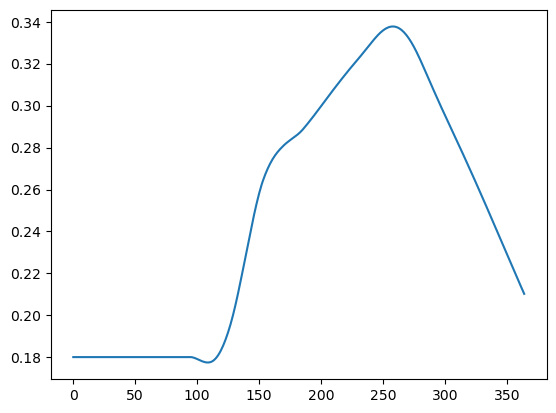

In [118]:
ndvi_ts.plot()

<Axes: >

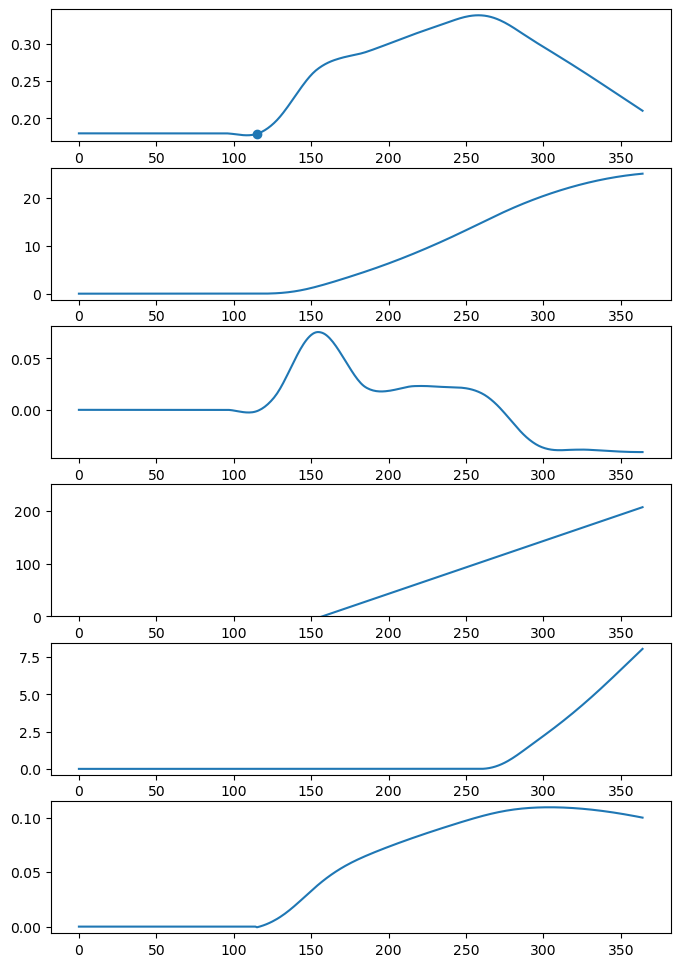

In [144]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=6, figsize=(8, 12))
test2['NDVI'].plot(ax=axs[0])
axs[0].scatter(y=test2['NDVI'][test2['SOS_doy'][0]], x=test2['SOS_doy'][0])
test2['iNDVI'].plot(ax=axs[1])
test2['NDVI_d30'].plot(ax=axs[2])
test2['t_peak_IRG'].plot(ax=axs[3], ylim=(0, 250))
test2['iNDVI_dry'].plot(ax=axs[4])
test2['NDVI_rate'].plot(ax=axs[5])